In [1]:
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight
from constants import *

In [415]:
x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-800:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-800:]
y_training = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_training-2])+1

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)
class_weights = tf.cast(tf.constant(class_weights), "float32")

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



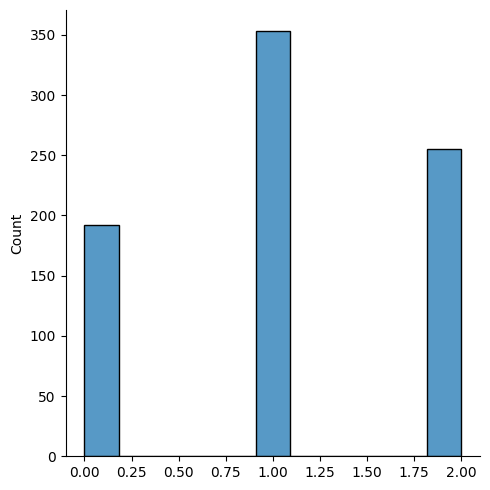

In [416]:
import seaborn as sns

sns.displot(y_training)

In [417]:
# class_weights_np = class_weights._numpy()
# class_weights_np[0] = class_weights_np[0]*1.7
# class_weights_np[1] = class_weights_np[1]/3
# class_weights_np[2] = class_weights_np[2]*1.1
# class_weights = tf.cast(tf.convert_to_tensor(class_weights_np), "float32")
# class_weights

In [418]:
def weightedLoss(weights=tf.constant([1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [419]:
# class_weights_dict[2]=0.01
# class_weights_dict[3]=0.01

In [420]:
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [470]:

def create_mlp_model(input_shape:Tuple[int, int], 
                     layer_number:int, 
                     neuron_number:List[int], 
                     activation:str|None="relu",
                     loss:str|None = "mae",
                     optimizer:str|None="adam") -> tf.keras.Model:

    """Creates a simple MLP regression model with 3-layers."""
    print(loss)

    layers = [tf.keras.layers.Dense(neuron_number[i], activation=activation) for i in range(layer_number)]
    layers.insert(0, tf.keras.layers.InputLayer(input_shape=input_shape))
    layers.insert(1, tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(NUMBER_OF_CLASSES-2, activation="softmax"))
    # layers.append(tf.keras.layers.Maximum())

    model = tf.keras.Sequential(layers)
    model.compile(
        # loss=loss,
        # loss=weightedLoss(class_weights),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        # optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.001, epsilon=1e-4),
        optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=0.001, epsilon=1e-3, rho=0.95),
        # optimizer = optimizer,
        metrics=["acc"]
    )

    return model

In [471]:
model = create_mlp_model(INPUT_DIM, 3, [32, 128, 512], activation="relu")

mae


In [472]:
## model training 
history = model.fit(x_training, 
                    y_training, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.10, 
                    class_weight=class_weights_dict,
                    callbacks=[lr_scheduler_plt]
                    )

Epoch 1/50
40/40 [==============================] - 1s 16ms/step - loss: 1.3355 - acc: 0.2931 - val_loss: 1.1648 - val_acc: 0.2625 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 0s 8ms/step - loss: 1.2815 - acc: 0.3028 - val_loss: 1.1498 - val_acc: 0.2625 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 0s 8ms/step - loss: 1.2379 - acc: 0.3111 - val_loss: 1.1379 - val_acc: 0.2375 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 0s 7ms/step - loss: 1.2036 - acc: 0.3208 - val_loss: 1.1279 - val_acc: 0.2500 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 0s 8ms/step - loss: 1.1758 - acc: 0.3361 - val_loss: 1.1204 - val_acc: 0.2875 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 0s 8ms/step - loss: 1.1549 - acc: 0.3250 - val_loss: 1.1143 - val_acc: 0.3250 - lr: 0.0010
Epoch 7/50
40/40 [==============================] - 0s 8ms/step - loss: 1.1372 - acc: 0.3375 - val_loss: 1.1093 - val_acc: 0.3500 - lr: 0.001

In [473]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_45 (Flatten)        (None, 972)               0         
                                                                 
 dense_244 (Dense)           (None, 32)                31136     
                                                                 
 dense_245 (Dense)           (None, 128)               4224      
                                                                 
 dense_246 (Dense)           (None, 512)               66048     
                                                                 
 dense_247 (Dense)           (None, 3)                 1539      
                                                                 
Total params: 102,947
Trainable params: 102,947
Non-trainable params: 0
_________________________________________________________________


In [474]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

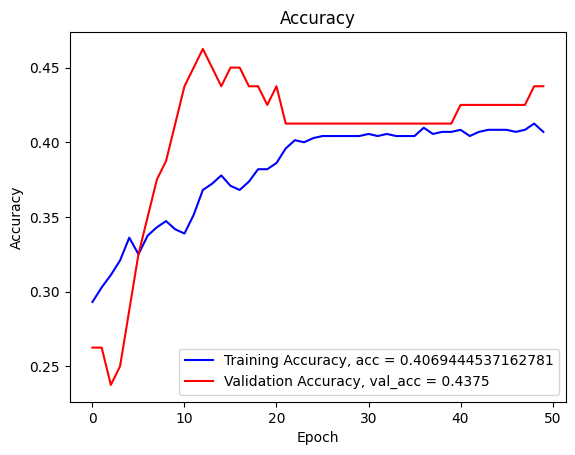

In [475]:
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

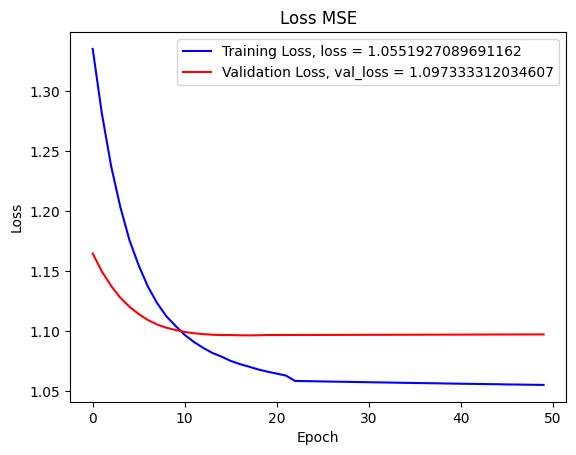

In [476]:
plt.plot(range(len(accuracy)), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(len(accuracy)), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [477]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)  
y_test = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_test-2])+1

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

In [478]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 11ms/step - loss: 1.1185 - acc: 0.3392


[1.11851966381073, 0.33924052119255066]

In [479]:
from sklearn.metrics import classification_report, confusion_matrix

In [480]:
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(classification_report(y_test, y_prediction))
print(result)

13/13 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.23      0.25      0.24       100
           1       0.52      0.32      0.39       189
           2       0.28      0.46      0.35       106

    accuracy                           0.34       395
   macro avg       0.35      0.34      0.33       395
weighted avg       0.38      0.34      0.34       395

[[0.23364486 0.25217391 0.26589595]
 [0.47663551 0.52173913 0.45086705]
 [0.28971963 0.22608696 0.28323699]]


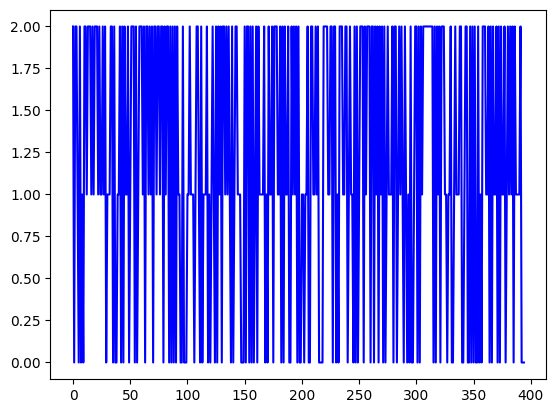

In [481]:
plt.plot(range(len(y_prediction)), y_prediction[:], "-b", label = f"Predicted")

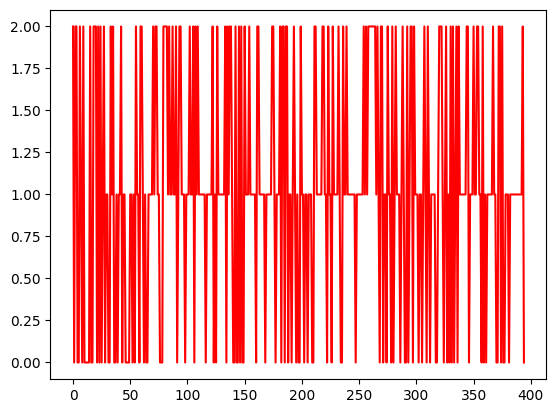

In [482]:
plt.plot(range(len(y_prediction)), y_test[:], "-r", label = f"Actual")

In [483]:
right_idx = np.where(y_prediction == y_test)[0]
idxs = range(len(y_prediction))
not_right_idx = [i for i in idxs if i not in right_idx]
right = np.zeros_like(y_prediction)
right[right_idx] = y_prediction[right_idx]
right[not_right_idx] = 3

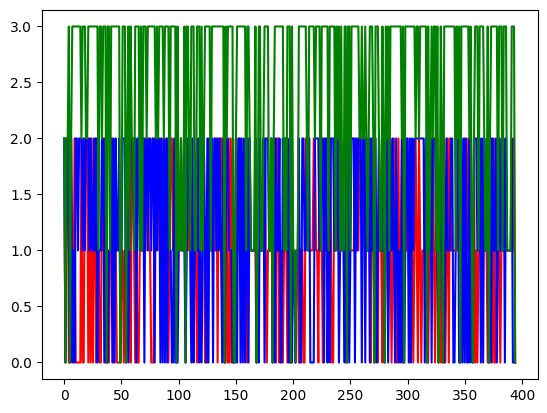

In [484]:
plt.plot(range(len(y_prediction)), y_test[:], "r", label = f"Actual")
plt.plot(range(len(y_prediction)), y_prediction[:], "b", label = f"Predicted")
plt.plot(range(len(y_prediction)), right[:], "g", label = f"Right")
plt.show()

In [485]:
y_pred_0 = np.where(y_prediction == 0)[0]
y_pred_1 = np.where(y_prediction == 1)[0]
y_pred_2 = np.where(y_prediction == 2)[0]

y_test_0 = np.where(y_test == 0)[0]
y_test_1 = np.where(y_test == 1)[0]
y_test_2 = np.where(y_test == 2)[0]

y_0_right = np.intersect1d(y_pred_0, y_test_0)
y_1_right = np.intersect1d(y_pred_1, y_test_1)
y_2_right = np.intersect1d(y_pred_2, y_test_2)

print(f"Class 0 accuracy: {len(y_0_right)/len(y_test_0)}")
print(f"Class 1 accuracy: {len(y_1_right)/len(y_test_1)}")
print(f"Class 2 accuracy: {len(y_2_right)/len(y_test_2)}")

Class 0 accuracy: 0.25
Class 1 accuracy: 0.31746031746031744
Class 2 accuracy: 0.46226415094339623


In [376]:
np.unique(y_prediction, return_counts=True)

(array([0, 1, 2]), array([ 40, 238, 117]))

In [144]:
y_prediction.shape

(395,)

In [145]:
y_prediction[200:300]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [146]:
np.unique(y_training, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 82,  83, 246, 266, 114, 109]))

# Grid Search